<a href="https://colab.research.google.com/github/KoNGoL/tfm_breast_cancer_detection/blob/main/Pruebas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
%pip install pydicom
%pip install opencv-python
%pip install pillow # optional 
%pip install pandas 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [12]:
#imports
import matplotlib.pyplot as plt
import pydicom as dicom
import os
# from google.colab.patches import cv2_imshow as cv2
import cv2 as cv2
import PIL # optional
import numpy as np


In [2]:
#initialize variables
in_path = "/home/fundamentia/python/tfm_breast_cancer_detection/pruebas/"
out_path = "/home/fundamentia/python/tfm_breast_cancer_detection/pruebas/procesadas/"
name = "1-1.dcm"
out_name = name + ".png"

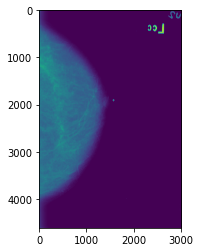

In [3]:
#convertir diccom a png
def convert_diccom_to_png(in_file, out_path):
  ds = dicom.dcmread(os.path.join(in_path, name))
  pixel_array_numpy = ds.pixel_array
  cv2.imwrite(os.path.join(out_path), pixel_array_numpy)

# image_path = in_path + "man2_mask2.dcm"
def show_diccom_img(diccom_path):
  ds = dicom.dcmread(diccom_path)
  plt.imshow(ds.pixel_array)
  plt.show()


convert_diccom_to_png(in_path + name, out_path + out_name)
show_diccom_img(in_path + name)

(4616, 3016, 3)
48 4568 30 2986


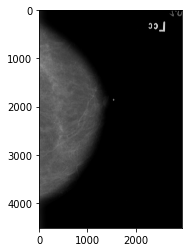

In [11]:
# recortar imagen
image_path = out_path + name + ".png"
def crop_img(image_path, output_path, x = 1, y = 4):
    img = cv2.imread(image_path)
    print(img.shape)
    y_start = int(img.shape[0]/(100-y))
    y_end = img.shape[0] - y_start
    x_start = int(img.shape[1]/(100-1))
    x_end = img.shape[1] - x_start
    print(y_start, y_end, x_start, x_end)

    crop_img = img[y_start:y_end, x_start:x_end]
    plt.imshow(crop_img)
    cv2.imwrite(os.path.join(output_path), crop_img)

out_crop_path = out_path + name + "_recortdada.png"
crop_img(image_path, out_crop_path)

In [ ]:
# reescalar imagen black  background
def rescale_img(image_path, output_path, scale = 0.5):
    img_black = np.zeros((512,512,3))
    img_object = cv2.imread(image_path)
    resize_dim = (640,640)
    img_resize = cv2.resize(img_object, resize_dim, interpolation = cv2.INTER_AREA)
    # positioning the image
    x = int((512 - img_resize.shape[0])/2.0)
    y = int((512 - img_resize.shape[1])/2.0)
    x_end = x + img_resize.shape[0]
    y_end = y + img_resize.shape[1]
    img_black[x:x_end,y:y_end,3] = img_resize
    image_final = image_black.copy()
    #image_final is the transformed image
